#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
# geo_standard = pd.read_csv(paths.GEO_STANDARD_AXON,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

#### Create simulation

In [2]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [3]:
cell_type = CellTypes.ACTIVE
loc_param = [0,0,50,np.pi/4,1,0]  # position (x,y,z,alpha,h,phi)
geo_param = [3,600.,1.25,0.28,.28,200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])
biophys = [] # (g_pas of soma, basal, apical, gNaTa_t of soma, apical, gSKv3_1 of soma, apical) (3.3e-5, 6.3e-5, 8.8e-5, 2.43, 0.0252, 0.983, 0.0112)
sim = Simulation(geometry = geo_standard, 
                 electrodes = elec_pos, 
                 cell_type = cell_type, 
                 loc_param = loc_param, 
                 geo_param = geo_param, 
                 biophys = biophys, 
                 gmax = .02, 
                 scale = 1.)  # 0.001 -0.012

<IPython.core.display.Javascript object>


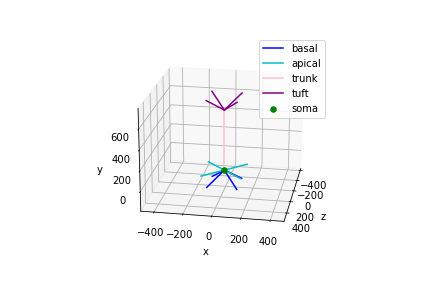

(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:xlabel='z', ylabel='x'>)

In [4]:
from cell_inference.utils.plotting.plot_morphology import plot_morphology
%matplotlib notebook

plot_morphology(sim)

Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [5]:
sec_list = [sim.cells[0].get_sec_by_id(sim.cells[0].sec_id_lookup[i][0]) for i in [3,4]]
dend_v = Recorder([sec_list[0](0.1),sec_list[0](0.5),sec_list[0](0.9),sec_list[1](0.5)])

In [6]:
sim.run_neuron_sim()
lfp = sim.get_lfp().T
t = sim.t()

Plot membrane voltage in soma, trunk and tuft.

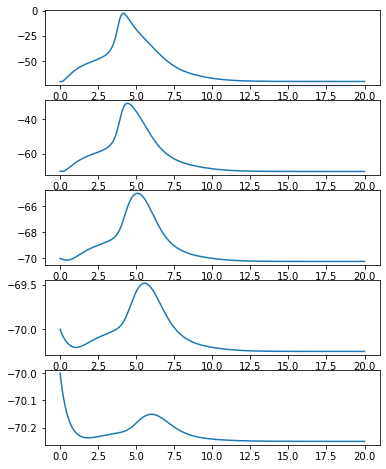

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,8))
plt.subplot(5,1,1)
plt.plot(t,sim.cells[0].v())
for i in range(v_dend.shape[0]):
    plt.subplot(5,1,i+2)
    plt.plot(t,v_dend[i,:])
plt.show()

Use functions in "utils" module to plot

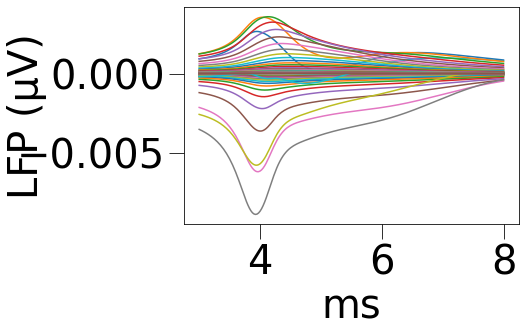

In [8]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces,plot_lfp_heatmap
%matplotlib inline

delay = 3.
window = [delay,delay+5.01]
# window = [5.,15.01]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_lfp_traces(t[idx],lfp[idx,:])

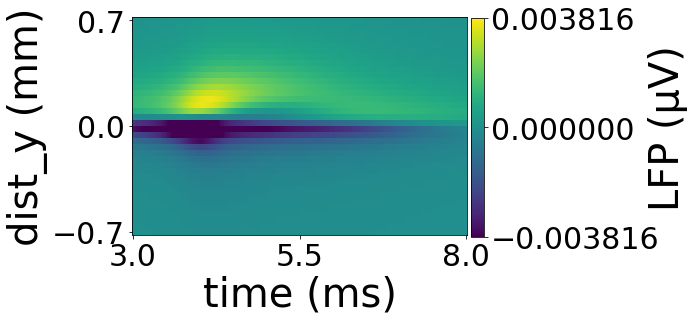

In [9]:
e_idx = slice(30,-30)  # electrodes index
fig,ax = plot_lfp_heatmap(t[idx],pos[e_idx,1],lfp[idx,e_idx],vlim='auto')
# set narrower "vlim" can help see more subtle difference in voltage

In [10]:
help(plot_lfp_heatmap) # check docstring

Help on function plot_lfp_heatmap in module cell_inference.utils.plotting.plot_results:

plot_lfp_heatmap(t: numpy.ndarray, elec_d: numpy.ndarray, lfp: numpy.ndarray, savefig: Union[str, NoneType] = None, vlim: str = 'auto', fontsize: int = 40, ticksize: int = 30, labelpad: int = -12, nbins: int = 3, cbbox: Union[List[float], NoneType] = None, cmap: str = 'viridis') -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot LFP heatmap.
    
    t: time points (ms). 1D array
    elec_d: electrode distance (um). 1D array
    lfp: LFP traces (uV). If is 2D array, each column is a channel.
    savefig: if specified as string, save figure with the string as file name.
    vlim: value limit for color map, using +/- 3-sigma of lfp for bounds as default. Use 'max' for maximum bound range.
    fontsize: size of font for display
    labelpad: Spacing in points from the Axes bounding box including ticks and tick labels.
    tick_length: length between ticks
    nbins: number of bins